# Load packages

In [35]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re, os
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Load data and analyze

=====Train dataset======
0    1102783
1      72726
Name: target, dtype: int64
=====Test dataset=======
0    122529
1      8084
Name: target, dtype: int64


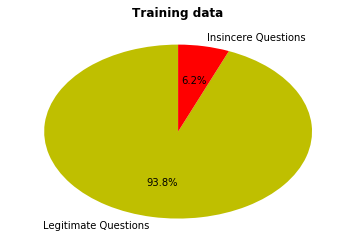

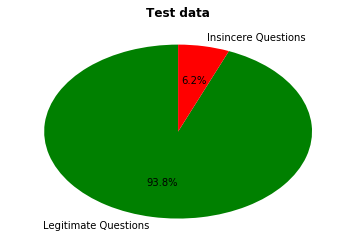

,qid,question_text,target
396890,4dc135b62e7d1dee8be7,Does abdominal size/strength correlate with he...,0
579802,719af0a616f39331d04a,Which celebrity of this era do you believe to ...,0
90860,11cd20ead60b0358e1b6,When did you stop eating meat?,0
297020,3a27b4672f61b16903fe,What are some best online film recommendation ...,0
105677,14b085fea2d77b088045,Are there any laptops that can be charged by U...,0


In [29]:
# Load data
data_df = pd.read_csv("../input/train.csv")

# Split into train and test
train_df, test_df = train_test_split(data_df, test_size = 0.1, random_state=55)

# Print data statistics 
print("=====Train dataset======")
print(train_df.target.value_counts())
print("=====Test dataset=======")
print(test_df.target.value_counts())
print("========================")

# Print pie chart
train_slices = train_df.target.value_counts().tolist()
labels = ['Legitimate Questions', 'Insincere Questions']
colors = ['y', 'r']
plt.pie(train_slices, labels = labels, colors = colors, startangle=90, autopct='%.1f%%')
plt.title('Training data', fontweight = "bold")
plt.show()
plt.figure()
test_slices = test_df.target.value_counts().tolist()
labels = ['Legitimate Questions', 'Insincere Questions']
colors = ['g', 'r']
plt.pie(test_slices, labels = labels, colors = colors, startangle=90, autopct='%.1f%%')
plt.title('Test data', fontweight = "bold")
plt.show()
train_df.head()


# Preprocess data

In [36]:
# Import stopwords
stopWords = set(stopwords.words('english'))
# Remove characters that are not alphabets
train_df["processed_text"] = train_df["question_text"].apply(lambda x: re.sub("[^a-zA-Z]", " ", x))
test_df["processed_text"] = test_df["question_text"].apply(lambda x: re.sub("[^a-zA-Z]", " ", x))
# Lower case all alphabets
train_df["processed_text"] = train_df["processed_text"].apply(lambda x: x.lower())
test_df["processed_text"] = test_df["processed_text"].apply(lambda x: x.lower())
# Remove stopwords
train_df["processed_text"] = train_df["processed_text"].apply(lambda x:" ".join([item for item in word_tokenize(x) if item not in stopWords]))
test_df["processed_text"] = test_df["processed_text"].apply(lambda x:" ".join([item for item in word_tokenize(x) if item not in stopWords]))
train_df.head()

,qid,question_text,target,processed_text
396890,4dc135b62e7d1dee8be7,Does abdominal size/strength correlate with he...,0,abdominal size strength correlate hernia occur...
579802,719af0a616f39331d04a,Which celebrity of this era do you believe to ...,0,celebrity era believe controversial
90860,11cd20ead60b0358e1b6,When did you stop eating meat?,0,stop eating meat
297020,3a27b4672f61b16903fe,What are some best online film recommendation ...,0,best online film recommendation systems
105677,14b085fea2d77b088045,Are there any laptops that can be charged by U...,0,laptops charged usb common


# Analyze most common words (unigrams) in train data

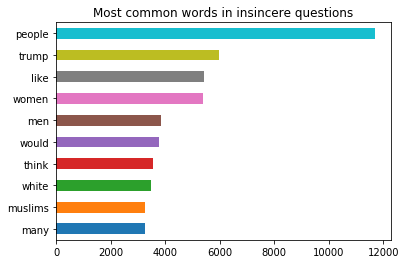

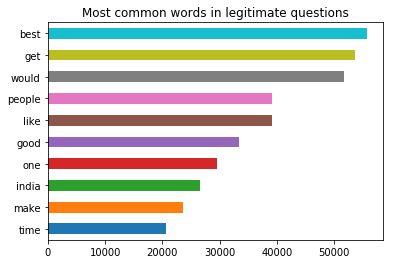

In [41]:
# Analyzing unigrams in insincere questions only
train_df_ones = train_df[train_df["target"]==1]
train_df_zeros = train_df[train_df["target"]==0]
most_common_words_ones = pd.Series(word_tokenize(" ".join(train_df_ones["processed_text"]))).value_counts()[:10][::-1]
plt.figure()
plt.title('Most common words in insincere questions')
most_common_words_ones.plot.barh()

# Analyzing unigrams in legitimate questions
train_df_zeros = train_df[train_df["target"]==0]
most_common_words_zeros = pd.Series(word_tokenize(" ".join(train_df_zeros["processed_text"]))).value_counts()[:10][::-1]
plt.figure()
plt.title('Most common words in legitimate questions')
most_common_words_zeros.plot.barh()

# Compute tf-idf transform

In [42]:
## Compute TfIdf transform of train and test data
tfidf = TfidfVectorizer(stop_words = 'english', ngram_range = (1,3), min_df = 5, max_df = 0.8)
tfidf.fit_transform(train_df["processed_text"].tolist() + test_df["processed_text"].tolist())
train_tfidf = tfidf.transform(train_df["processed_text"].tolist())
test_tfidf = tfidf.transform(test_df["processed_text"].tolist())

# Use validation set to choose parameters

In [43]:
train_df2, val_df2 = train_test_split(train_df, test_size = 0.05, random_state=55)
train_tfidf2 = tfidf.transform(train_df2["processed_text"].tolist())
val_tfidf2 = tfidf.transform(val_df2["processed_text"].tolist())
ls_values_C = [0.01, 0.1, 1, 10]
ls_values_th = np.arange(0.5, 0.9, 0.05)

for value_C in ls_values_C:
    logreg = LogisticRegression(C = value_C, solver = 'liblinear', class_weight = 'balanced')
    logreg.fit(train_tfidf2, train_df2.target)
    val_pred = logreg.predict_proba(val_tfidf2)[:,1]
    ls_f1_thresholds = []
    for value_th in ls_values_th:
        ls_f1_thresholds.append(f1_score(val_pred>value_th, val_df2.target, pos_label=1))
    print('F1 scores with different thresholds at C = {} are {}'.format(value_C, ls_f1_thresholds))

F1 scores with different thresholds at C = 0.01 are [0.46236811254396243, 0.49299617973440063, 0.5098286555240198, 0.5157096424702059, 0.4976024112892177, 0.4563380281690141, 0.3942497753818508, 0.30107084019769353]
F1 scores with different thresholds at C = 0.1 are [0.5066195939982348, 0.5320412083115069, 0.5530948324815446, 0.5670050240951502, 0.575058508859913, 0.5761186770428016, 0.5645226265610312, 0.5403874813710879]
F1 scores with different thresholds at C = 1 are [0.5459935478245707, 0.5658102216862999, 0.5821513002364067, 0.5941544885177453, 0.6006651884700666, 0.6036708111308466, 0.6023517511695535, 0.5887850467289719]
F1 scores with different thresholds at C = 10 are [0.5526547374596655, 0.5627687896784763, 0.5673743731996158, 0.5737211634904714, 0.5746938775510204, 0.5779951100244499, 0.5829699923057194, 0.5801338980735073]


# Logistic Regression

In [49]:
logreg = LogisticRegression(C = 1.0, solver = 'liblinear', class_weight = 'balanced')
logreg.fit(train_tfidf2, train_df2.target)
test_pred = logreg.predict_proba(test_tfidf)[:,1] > 0.75
print('Mean Accuracy (test data): ',logreg.score(test_tfidf, test_df.target))
print('F1 score insincere questions (test data): ',f1_score(test_pred, test_df.target, pos_label=1))

Mean Accuracy (test data):  0.911417699616424
F1 score insincere questions (test data):  0.6007943323314727


# Analyzing success and failures

In [88]:
# Indeces of insincere questions correctly identified 
idx_mistakes = (test_pred == 1) & (test_df.target == 1)
bold_begin = '\033[1m'
bold_end = '\033[0m'
print("{}{}{}".format(bold_begin, "Insincere questions correctly identified:", bold_end))
test_df[idx_mistakes].sample(n = 10)

Insincere questions correctly identified:


,qid,question_text,target,processed_text
758416,94980117a140a86aec4a,"Will Trump finally close the criminal, corrupt...",1,trump finally close criminal corrupt corporate...
11388,023dd124e7f79ab80849,Why are men with high and low IQ more common t...,1,men high low iq common women
478399,5dadf5ffa51839a040bb,Why are liberals so delusional?,1,liberals delusional
694695,8810d4b39f9a08df9777,Don't Americans feel enslaved since they have ...,1,americans feel enslaved since tell policeman e...
530057,67c80a9af98cf04ceebd,When most Bangladeshi consider themselves Bang...,1,bangladeshi consider bangladeshi bengali first...
959688,bc06453c7c943e2bc209,"If the democrats in the USA ""asks"" millions of...",1,democrats usa asks millions democrats register...
92975,123474aecf7c836136d4,Would forcing men to be injected with estrogen...,1,would forcing men injected estrogen instead te...
566940,6f14514a5a345f0384f1,What does the left think of their celebrities ...,1,left think celebrities congressmen tried bring...
823940,a174f276825f47a3f07e,Should white Americans pay a white privilege tax?,1,white americans pay white privilege tax
341465,42e33f67535fdbbf16cf,"Did Obama want to bring freedom to Syria, like...",1,obama want bring freedom syria like hitler tri...


In [86]:
# Indeces of insincere questions correctly identified 
idx_mistakes = (test_pred == 0) & (test_df.target == 1)
print("{}{}{}".format(bold_begin, "... and the insincere questions not identified by the model:", bold_end))
test_df[idx_mistakes].sample(n = 10)

... and the insincere questions not identified by the model:


,qid,question_text,target,processed_text
927983,b5db2aaf1ac1e3862ae1,Why are Italian people so noisy?,1,italian people noisy
136569,1abc0aa692917c698a1f,Now that Facebook has revealed how it can mine...,1,facebook revealed mine use user data indians g...
113275,162956940b7b92340c26,Is patriarchy a result of natural selection fo...,1,patriarchy result natural selection humans goi...
269399,34bc4bef4a9876f85fe4,What was the best way to deal with debt collec...,1,best way deal debt collectors
1111168,d9bb754bd0adb4df0ab0,Is killing net neutrality our chance to make A...,1,killing net neutrality chance make americans a...
299151,3a93e86388a2ca40c125,Why do police pull you over and harass you whe...,1,police pull harass right travel without licens...
422108,52bc5784380a230e32e1,If astrologers are lunatics who talk to the sk...,1,astrologers lunatics talk sky priests
310008,3cba923004b082cad5e6,Why did the Romans not occupy what is now Saud...,1,romans occupy saudi arabia mecca medina smell oil
366509,47d636d195217e110293,How has India had developed its culture: noddi...,1,india developed culture nodding head means sha...
1009116,c5bc6c45b5cbda5769e0,Is mayonnaise an instrument?,1,mayonnaise instrument
